In [1]:
# importing tools 
import s3fs
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
#for removing warnings
import warnings

In [2]:
# open the data with s3fs from the databucket 
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
data_path1 = 's3://data/CREG12.L75-REF08_mesh_zgr.zarr'
data_path2 = 's3://data/vel_dataIII.zarr/vel_dataIII.zarr'
data_path3 = 's3://data/lat_lon_scalar.zarr'

remote_files1 = fsg.glob(data_path1)
remote_files2 = fsg.glob(data_path2)
remote_files3 = fsg.glob(data_path3)

store1 = s3fs.S3Map(root=data_path1, s3=fsg, check=False)
store2 = s3fs.S3Map(root=data_path2, s3=fsg, check=False)
store3 = s3fs.S3Map(root=data_path3, s3=fsg, check=False)

dzz = xr.open_zarr(store=store1, consolidated=True)
dv = xr.open_zarr(store=store2, consolidated=True)
dl = xr.open_zarr(store=store3, consolidated=True)

In [24]:
lat = dzz.nav_lat.isel(x=slice(200,1400),y=slice(650,1800))
lon = dzz.nav_lon.isel(x=slice(200,1400),y=slice(650,1800))
lon_flat = dzz.nav_lon.isel(x=slice(200,1400),y=slice(650,1800)).values.flatten()
lat_flat = dzz.nav_lat.isel(x=slice(200,1400),y=slice(650,1800)).values.flatten()

In [4]:
p_list = [(31.13247,81.24202),(31.13533,81.24255),(31.14506,81.24587)
          ,(011.1189, 69.5289)
          #,(013.16845,68.58759),(013.19866,68.56109),(012.45082,68.50128)
          ,(5.57541,79.37209),(5.48733,80.03876),(5.56333,79.44093)]

In [5]:
p = p_list[0]

In [8]:
lat_value = [min(lat_flat, key=lambda x:abs(x-h)) for h in [p[1]]]
lon_value = [min(lon_flat, key=lambda x:abs(x-h)) for h in [p[0]]]

In [15]:
print('lat value closest to point ', p[1],'is ', lat_value)
print('lon value closest to point ', p[0],'is ', lon_value)

idx_lat = np.where(lat.values==lat_value)
idx_lon = np.where(lon.values==lon_value)
print('index for lat :', idx_lat)
print('index for lon :', idx_lon)
print('---------------------------')
print('lat values: ', lat[idx_lat].values)
print('lon values with lat idx: ', lon[idx_lat].values)
print('---------------------------')
print('lon values: ', lon[idx_lon].values)
print('lat values with lon idx: ', lat[idx_lon].values)
print('-----------------------------')

lat value closest to point  81.24202 is  [81.242035]
lon value closest to point  31.13247 is  [31.133223]
index for lat : (array([815]), array([577]))
index for lon : (array([483]), array([784]))
---------------------------
lat values:  [[81.242035]]
lon values with lat idx:  [[-174.98457]]
---------------------------
lon values:  [[31.133223]]
lat values with lon idx:  [[83.84839]]
-----------------------------


In [17]:
idx_l = []
diff_lon = []
lon_l = []
for i,item in enumerate(lon_flat):
    d = item - p[0]
    if abs(d)<0.5:
        idx_l.append(i) 
        diff_lon.append(d) 
        lon.append(item)

In [18]:
diff_lonlat = []
diff_lat = []
idx_lat = []
for i in idx_l:
    d = lat_flat[i]-p[1]
    if abs(d)<1:
        diff_lonlat.append(d)
        diff_lat.append(lat_flat[i])
        idx_lat.append(i)

In [ ]:
print(p[1])
print(p[0])
print(diff_lat[97])
print(idx_lat[97])
print(lat_flat[idx_lat[97]])
print(lon_flat[idx_lat[97]])
print(np.where(lat.values==lat_flat[idx_lat[97]]))
i_lat = np.where(lat.values==lat_flat[idx_lat[97]])
#diff_lat[90:110]

In [ ]:
idx_moor = dict()

idx_moor['punkt'] = [p[0]]

(array([123, 567]), array([584, 584]))
(array([212, 478]), array([854, 854]))
(array([320, 370]), array([410, 410]))
(array([266, 424]), array([18, 18]))
(array([ 43, 647]), array([92, 92]))
(array([215, 475]), array([383, 383]))
(array([144, 546]), array([469, 469]))
(array([277, 413]), array([935, 935]))


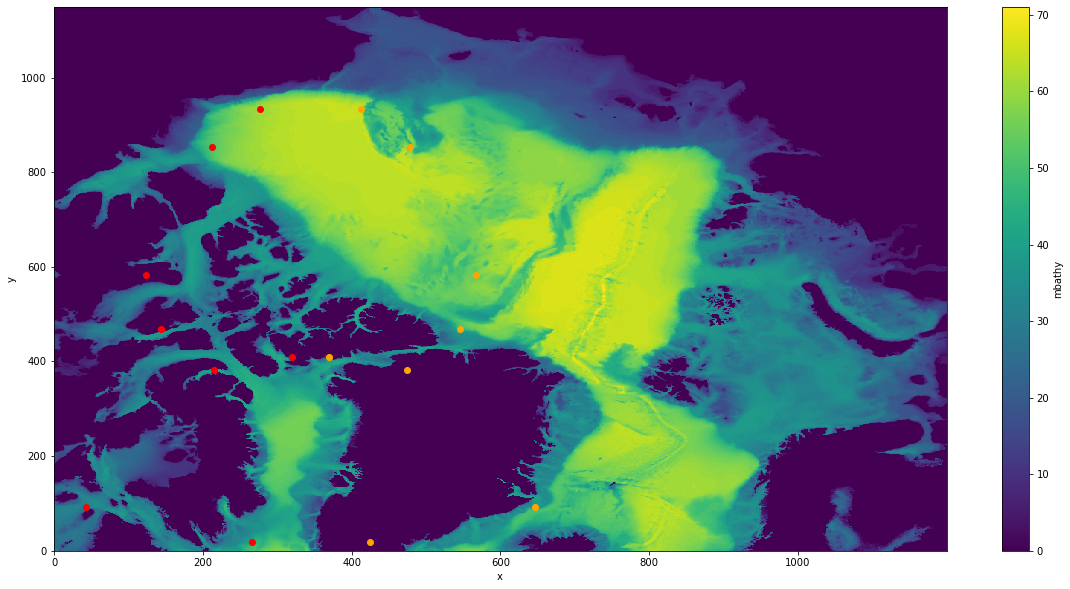

In [81]:
fig, ax = plt.subplots(figsize=(20,10))
bathym.plot()

for p in p_list:
    lat_p  = p[1]
    
    # sceraching for closest value of latitude:
    lat_value = [min(lat_f, key=lambda x:abs(x-h)) for h in [lat_p]]
    idx = np.where(lat.values==lat_value)
    print(idx)
    punktI = (idx[0][0],idx[1][0])
    punktII = (idx[0][1],idx[1][1])
    ax.plot(punktI[0], punktI[1], marker='o', color='r')
    ax.plot(punktII[0], punktII[1], marker='o', color='orange')
    

In [35]:
idx

(array([123, 567]), array([584, 584]))

In [38]:
idx[0][1]

567

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
bathym.plot()
for p in p_latlonI:
    ax.plot(848, 204, marker='o', color='r')

In [52]:
lat_f

array([65.65805 , 65.67766 , 65.69729 , ..., 59.296104, 59.273724,
       59.251328], dtype=float32)

In [56]:
print(lat.max().values,lat.min().values)

89.95911 59.251328


In [58]:
print(lat_f[50],lat[50].values)

66.6645 [66.65048  66.671135 66.6918   ... 66.65654  66.62462  66.59268 ]


In [66]:
inx = np.where(lat.values==lat_f[50])
inx

(array([  0, 690]), array([50, 50]))

In [77]:
å = (inx[0][0],inx[1][0])
å

(0, 50)

In [67]:
print(lat[0,50].values)
print(lat[690,50].values)
lat_f[50]

66.6645
66.6645


66.6645

In [70]:
lat[inx].values

array([[66.6645, 66.6645],
       [66.6645, 66.6645]], dtype=float32)

In [82]:
lon[inx].values

array([[ -86.29264,  -86.29264],
       [-127.70736, -127.70736]], dtype=float32)

In [83]:
lon_f[50]

-86.29264

In [69]:
å[0][0]

array([66.6645, 66.6645], dtype=float32)

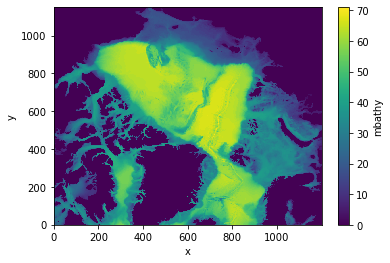

In [28]:
bathym = dzz.mbathy.isel(t=0, x=slice(200,1400), y=slice(650,1800))
bathym.plot()

In [12]:
bathym_ = dv.mbathy
lat = bathym_.nav_lat
lon = bathym_.nav_lon
lat_f = bathym_.nav_lat.values.flatten()
lon_f = bathym_.nav_lon.values.flatten()

In [13]:
lat.values

array([[65.65805 , 65.67766 , 65.69729 , ..., 65.47358 , 65.44332 ,
        65.413055],
       [65.679245, 65.698875, 65.71853 , ..., 65.49864 , 65.468346,
        65.43805 ],
       [65.70039 , 65.72004 , 65.73972 , ..., 65.52364 , 65.493324,
        65.46298 ],
       ...,
       [60.260918, 60.274937, 60.288967, ..., 59.362286, 59.339825,
        59.31735 ],
       [60.230377, 60.244366, 60.258366, ..., 59.32921 , 59.30679 ,
        59.28435 ],
       [60.19979 , 60.213753, 60.227726, ..., 59.296104, 59.273724,
        59.251328]], dtype=float32)

In [4]:
p_list = [(31.13247,81.24202),(31.13533,81.24255),(31.14506,81.24587)
          ,(011.1189, 69.5289),(013.16845,68.58759),(013.19866,68.56109),(012.45082,68.50128)
          ,(5.57541,79.37209),(5.48733,80.03876),(5.56333,79.44093)]

In [10]:
p_list[0][1]

81.24202

In [15]:
p = p_list[0]
p[1]

81.24202

AttributeError: 'list' object has no attribute 'shape'

In [30]:
p_latlonI = []
p_latlonII = []

for p in p_list:
    lat_p  = p[1]
    
    # sceraching for closest value of latitude:
    lat_value = [min(lat_f, key=lambda x:abs(x-h)) for h in [lat_p]]
    idx = np.where(lat.values==lat_value)
    lat_val = lat[idx].values
    lon_val = lon[idx].values
    
    #p_latlonI.append((lat_val[0][0],lon_val[0][0]))
    #p_latlonI.append((lat_val[1][0],lon_val[1][0]))
    
    print(f'for punkt {p}: ' )
    print('lat ', lat_val[0][0], lat_val[1][0])
    print('lon ', lon_val[0][0], lon_val[1][0])
    print('------------------------------------------------')

for punkt (31.13247, 81.24202): 
lat  81.24196 81.24196
lon  -37.125473 -176.87453
------------------------------------------------
for punkt (31.13533, 81.24255): 
lat  81.24253 81.24253
lon  38.553555 107.44645
------------------------------------------------
for punkt (31.14506, 81.24587): 
lat  81.245865 81.245865
lon  -102.127205 -111.872795
------------------------------------------------
for punkt (11.1189, 69.5289): 
lat  69.52891 69.52891
lon  -102.992645 -111.007355
------------------------------------------------
for punkt (13.16845, 68.58759): 


IndexError: index 1 is out of bounds for axis 0 with size 1

In [29]:
p_latlonI#[0][0]

[(81.24196, -37.125473),
 (81.24196, -176.87453),
 (81.24253, 38.553555),
 (81.24253, 107.44645),
 (81.245865, -102.127205),
 (81.245865, -111.872795),
 (69.52891, -102.992645),
 (69.52891, -111.007355),
 (68.58759, -143.47713)]

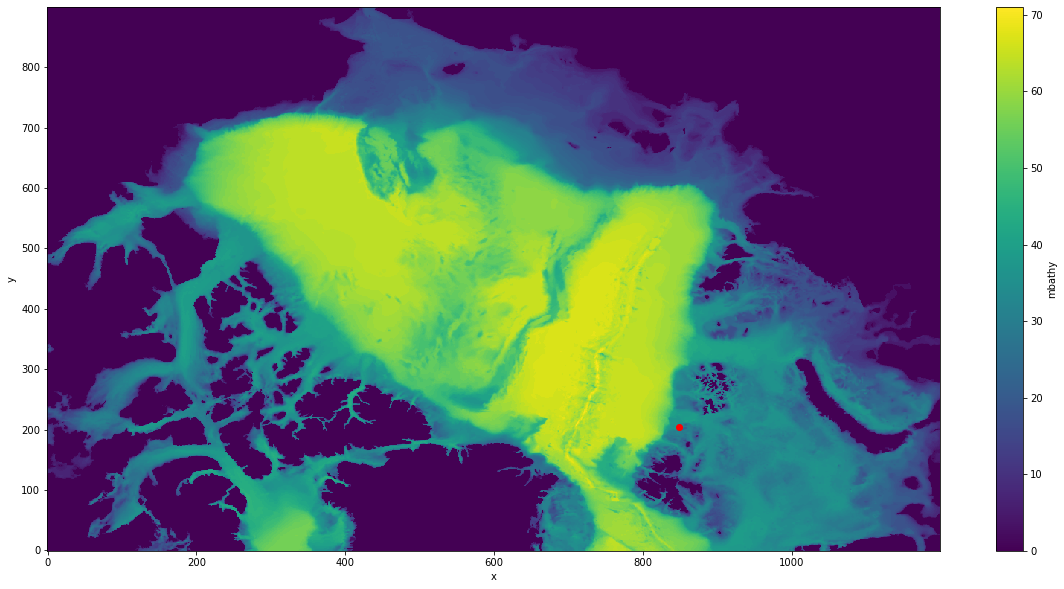

In [128]:
fig, ax = plt.subplots(figsize=(20,10))
bathym.plot()
ax.plot(848, 204, marker='o', color='r')

Deler inn i tre kart for hvert sted

In [88]:
# Barents sea

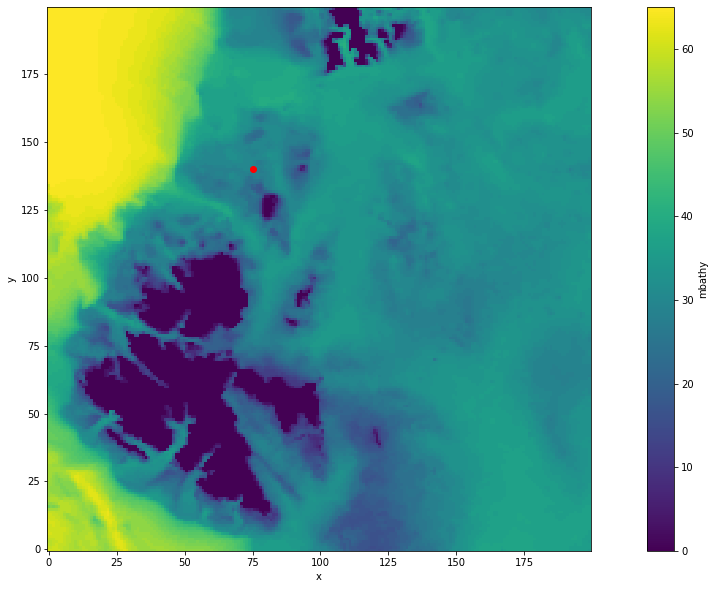

In [100]:
fig, ax = plt.subplots(figsize=(20,10))
bathym.isel(x=slice(780,980), y=slice(50,250)).plot()
ax.plot(75,140,marker='o', color='r')
ax.set_aspect('equal')

# Location for each mooring: 

- d13: latitude: 81◦24.202’N
       longitude: 31◦13.247’E
- d15: latitude: 81◦24.255’N
       longitude: 31◦13.533’E
- d17: latitude: 81◦24.587’N
       lonitude: 31◦14.506’E
- MB: latitude: 69 N 52.89
      longitude: 011E 11.89
- MW: latitude: 68 N 58.759
      longitude: 013E 16.845 
- MN: latitude: 68 N 56.109
      lonitude: 013E 19.866
- MS: latitude: 68 N 50.128
      longitude: 012E 45.082   
- y1: longitude: 79.37209
      lontitude: 5.57541
- y2: latitude: 80.03876
      longitude: 5.48733
- y3: latitude: 79.44093
      longitude: 5.56333


In [ ]:
p_list = [(31.13247,81.24202),(31.13533,81.24255),(31.14506,81.24587)
          ,(011.1189, 69.5289),(013.16845,68.58759),(013.19866,68.56109),(012.45082,68.50128)
          ,(5.57541,79.37209),(5.48733,80.03876),(5.56333,79.44093)]

In [147]:
p = p_list[0]
p_lat = p[1]
p_lon = p[0]
p_lat

81.24202

In [159]:
bathym.isel()

<xarray.DataArray 'mbathy' (t: 1, y: 900, x: 1200)>
dask.array<xarray-mbathy, shape=(1, 900, 1200), dtype=int16, chunksize=(1, 900, 1200), chunktype=numpy.ndarray>
Coordinates:
    nav_lat  (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
Dimensions without coordinates: t, y, x

In [166]:
np.where((lat==70), lat)
np.where((lon==30), lon)

ValueError: either both or neither of x and y should be given

In [164]:
lat

<xarray.DataArray 'nav_lat' (y: 900, x: 1200)>
dask.array<xarray-nav_lat, shape=(900, 1200), dtype=float32, chunksize=(900, 1200), chunktype=numpy.ndarray>
Coordinates:
    nav_lat  (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
Dimensions without coordinates: y, x
Attributes:
    long_name:      Latitude
    nav_model:      grid_U
    standard_name:  latitude
    units:          degrees_north

In [160]:
dv

<xarray.Dataset>
Dimensions:        (depth: 75, t: 1, time_counter: 73, x: 1200, y: 900)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    nav_lat        (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    time_centered  (time_counter) object dask.array<chunksize=(73,), meta=np.ndarray>
  * time_counter   (time_counter) object 2000-01-03 12:00:00 ... 2000-12-29 1...
Dimensions without coordinates: t, x, y
Data variables:
    mbathy         (t, y, x) int16 dask.array<chunksize=(1, 900, 1200), meta=np.ndarray>
    vel            (time_counter, depth, y, x) float32 dask.array<chunksize=(1, 75, 900, 1200), meta=np.ndarray>
    vomecrty       (time_counter, depth, y, x) float32 dask.array<chunksize=(1, 75, 900, 1200), meta=np.ndarray>
    vozocrtx       (time_counter, depth, y, x) float32 dask.array<chunksize=(1, 75, 900, 1200), meta=np.ndarray>
Attributes:
    cell_methods:        time: mean (interval: 360 s)
    interval_operation:  360 s
    interval_write:      5 d
    long_name:           sea_water_x_velocity
    online_operation:    average
    standard_name:       sea_water_x_velocity
    units:               m/s

In [ ]:
dzz

In [129]:
lat = bathym.nav_lat
lon = bathym.nav_lon

In [133]:
b = lon.isel(x=slice(840,850), y=slice(180,190)).values
b

array([[29.943398, 30.104471, 30.26462 , 30.42385 , 30.582165, 30.739574,
        30.89608 , 31.051691, 31.206413, 31.360252],
       [30.132492, 30.293442, 30.45346 , 30.612553, 30.77073 , 30.927994,
        31.08435 , 31.239807, 31.394373, 31.548048],
       [30.322594, 30.48341 , 30.643291, 30.802242, 30.96027 , 31.117382,
        31.273584, 31.42888 , 31.58328 , 31.736786],
       [30.513704, 30.67438 , 30.834116, 30.992918, 31.150791, 31.307745,
        31.463783, 31.618912, 31.773138, 31.926468],
       [30.705824, 30.866352, 31.025936, 31.184582, 31.342293, 31.49908 ,
        31.65495 , 31.809902, 31.963947, 32.117092],
       [30.898958, 31.059332, 31.218756, 31.377237, 31.53478 , 31.691395,
        31.847084, 32.001854, 32.155712, 32.308666],
       [31.09311 , 31.25332 , 31.412577, 31.570887, 31.728254, 31.884686,
        32.040188, 32.19477 , 32.348434, 32.50119 ],
       [31.28828 , 31.448322, 31.607405, 31.765533, 31.922714, 32.07896 ,
        32.234272, 32.388653, 32.5421

In [136]:
a = lat.isel(x=slice(840,850), y=slice(180,190)).values
a

array([[80.85306 , 80.825195, 80.79727 , 80.76927 , 80.74121 , 80.71308 ,
        80.68488 , 80.656624, 80.628296, 80.5999  ],
       [80.88066 , 80.85273 , 80.82472 , 80.796646, 80.76851 , 80.7403  ,
        80.71202 , 80.683685, 80.65528 , 80.62681 ],
       [80.90816 , 80.88014 , 80.85205 , 80.823906, 80.795685, 80.767395,
        80.739044, 80.710625, 80.682144, 80.653595],
       [80.935524, 80.90743 , 80.879265, 80.851036, 80.82274 , 80.79437 ,
        80.765945, 80.73745 , 80.708885, 80.68026 ],
       [80.962776, 80.9346  , 80.90636 , 80.878044, 80.84967 , 80.82123 ,
        80.79272 , 80.764145, 80.73551 , 80.70681 ],
       [80.98991 , 80.961655, 80.93333 , 80.90494 , 80.87648 , 80.84796 ,
        80.819374, 80.790726, 80.76201 , 80.73323 ],
       [81.016914, 80.98858 , 80.96018 , 80.93171 , 80.903175, 80.87458 ,
        80.84591 , 80.81718 , 80.78838 , 80.75953 ],
       [81.0438  , 81.01538 , 80.9869  , 80.95835 , 80.92974 , 80.90106 ,
        80.87232 , 80.843506, 80.8146

In [130]:
a[4][8]

81.24131

In [123]:
lat.isel(x=slice(840,850), y=slice(204,205)).values

array([[81.481285, 81.4515  , 81.421646, 81.39174 , 81.36177 , 81.33175 ,
        81.30166 , 81.271515, 81.24131 , 81.21105 ]], dtype=float32)

<xarray.DataArray 'mbathy' (t: 1, y: 900, x: 1200)>
dask.array<xarray-mbathy, shape=(1, 900, 1200), dtype=int16, chunksize=(1, 900, 1200), chunktype=numpy.ndarray>
Coordinates:
    nav_lat  (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
Dimensions without coordinates: t, y, x

In [155]:
dzz

<xarray.Dataset>
Dimensions:       (t: 1, x: 1580, y: 1801, z: 75)
Dimensions without coordinates: t, x, y, z
Data variables: (12/19)
    e3t_0         (t, z, y, x) float64 dask.array<chunksize=(1, 75, 1801, 1580), meta=np.ndarray>
    e3t_1d        (t, z) float64 dask.array<chunksize=(1, 75), meta=np.ndarray>
    e3u_0         (t, z, y, x) float64 dask.array<chunksize=(1, 75, 1801, 1580), meta=np.ndarray>
    e3v_0         (t, z, y, x) float64 dask.array<chunksize=(1, 75, 1801, 1580), meta=np.ndarray>
    e3w_0         (t, z, y, x) float64 dask.array<chunksize=(1, 75, 1801, 1580), meta=np.ndarray>
    e3w_1d        (t, z) float64 dask.array<chunksize=(1, 75), meta=np.ndarray>
    ...            ...
    mbathy        (t, y, x) int16 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    misf          (t, y, x) int16 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lev       (z) float32 dask.array<chunksize=(75,), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    time_counter  (t) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    TimeStamp:  06/06/2019 11:16:36 +0200
    file_name:  mesh_zgr.nc

In [200]:
latnull = lat.values.flatten()
lonnull = lon.values.flatten()

In [230]:
lon.values

array([[ -89.1416  ,  -89.08634 ,  -89.03102 , ...,   42.00175 ,
          42.064854,   42.127846],
       [ -89.185974,  -89.13083 ,  -89.07562 , ...,   42.071568,
          42.134567,   42.197456],
       [ -89.23045 ,  -89.17542 ,  -89.12033 , ...,   42.14156 ,
          42.204456,   42.267242],
       ...,
       [-131.83008 , -131.90262 , -131.9752  , ...,  114.89426 ,
         114.81782 ,  114.74144 ],
       [-131.854   , -131.92659 , -131.99924 , ...,  114.93157 ,
         114.855095,  114.77868 ],
       [-131.87785 , -131.9505  , -132.02318 , ...,  114.968765,
         114.89225 ,  114.815796]], dtype=float32)

In [206]:
np.where((latnull==65.65805) & (lonnull==-89.1416))[0][0]

0

In [ ]:
lat_value = [min(latnull, key=lambda x:abs(x-h)) for h in [morlat1, morlat2, morlat3]]

In [209]:
lat_value = [min(latnull, key=lambda x:abs(x-h)) for h in [81.24202]]

In [210]:
lat_value

[81.24196]

In [207]:
temp = 65.71853 

In [212]:
idx = np.where(lat.values==lat_value)

In [217]:
idx

(array([123, 567]), array([584, 584]))

In [231]:
lat[idx].values

array([[81.24196, 81.24196],
       [81.24196, 81.24196]], dtype=float32)

In [226]:
d = lon[idx].values
d

array([[ -37.125473,  -37.125473],
       [-176.87453 , -176.87453 ]], dtype=float32)

In [229]:
print(d[0][0])
d[1][0]

-37.125473


-176.87453

In [172]:
latnull[0,0]

65.65805

In [196]:
a=lat.where(lat.nav_lat==70, lat.nav_lon==30)
a.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [199]:
for i in range(len(a)):
    for j in range(len(a[:,0])):
        if a[j,i].isnull()==False:
            print(a)

<xarray.DataArray 'nav_lat' (y: 900, x: 1200)>
dask.array<where, shape=(900, 1200), dtype=float32, chunksize=(900, 1200), chunktype=numpy.ndarray>
Coordinates:
    nav_lat  (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
Dimensions without coordinates: y, x
Attributes:
    long_name:      Latitude
    nav_model:      grid_U
    standard_name:  latitude
    units:          degrees_north
<xarray.DataArray 'nav_lat' (y: 900, x: 1200)>
dask.array<where, shape=(900, 1200), dtype=float32, chunksize=(900, 1200), chunktype=numpy.ndarray>
Coordinates:
    nav_lat  (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
Dimensions without coordinates: y, x
Attributes:
    long_name:      Latitude
    nav_model:      grid_U
    standard_name:  latitude
    units:          degrees_north
<xarray.DataArray 'nav_lat' 

KeyboardInterrupt: 

In [145]:
lat.nav_lat.values.shape

(900, 1200)

In [180]:
lat

<xarray.DataArray 'nav_lat' (y: 900, x: 1200)>
dask.array<xarray-nav_lat, shape=(900, 1200), dtype=float32, chunksize=(900, 1200), chunktype=numpy.ndarray>
Coordinates:
    nav_lat  (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
Dimensions without coordinates: y, x
Attributes:
    long_name:      Latitude
    nav_model:      grid_U
    standard_name:  latitude
    units:          degrees_north

In [184]:
print(p_lat,p_lon)

81.24202 31.13247


In [188]:
lat.sel(lat.nav_lat=p_lat, lat.nav_lon=p_lon
        , method='nearest'
       )

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (<ipython-input-188-871f729d750c>, line 1)

In [190]:
lat.sel(lat.nav_lat==p_lat, lat.nav_lon==p_lon
        , method='nearest'
       )

ValueError: the first argument to .sel must be a dictionary

In [134]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}/*'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
    # rename variabel
    dset = dset.rename({'__xarray_dataarray_variable__' : 'vel'})
    return dset

In [135]:
ds = open_s3fs('PC-data')

In [137]:
u = du.vozocrtx.isel(y=slice(900,1800), x=slice(200,1400))
#v = dv.vomecrty.isel(y=slice(900,1800), x=slice(200,1400))
mbathy = ds.mbathy.isel(y=slice(900,1800), x=slice(200,1400))

In [126]:
def dyp(depth): 
    depth = int(depth)
    dyp = np.zeros(depth, dtype=int)
    #d = du.depth.isel(depth=depth).values
    for i in range(len(dyp)):
        d = du.depth[i].values #gdepth_1d
        dyp[i] = d
    return dyp  

In [32]:
# open the data with s3fs from the databucket 
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
data_path = 's3://data/PCz.zarr/'
remote_files = fsg.glob(data_path)

store = s3fs.S3Map(root=data_path, s3=fsg, check=False)
pc = xr.open_zarr(store=store, consolidated=True)
pc = pc.rename_dims({'dim_0': 'x_', 'dim_1': 'y_'})
pc 

<xarray.Dataset>
Dimensions:  (x_: 1200, y_: 900)
Dimensions without coordinates: x_, y_
Data variables:
    PC11     (x_, y_) float64 dask.array<chunksize=(300, 225), meta=np.ndarray>
    PC12     (x_, y_) float64 dask.array<chunksize=(300, 225), meta=np.ndarray>
    depth    (x_, y_) float64 dask.array<chunksize=(300, 225), meta=np.ndarray>
    x        int64 ...
    y        int64 ...

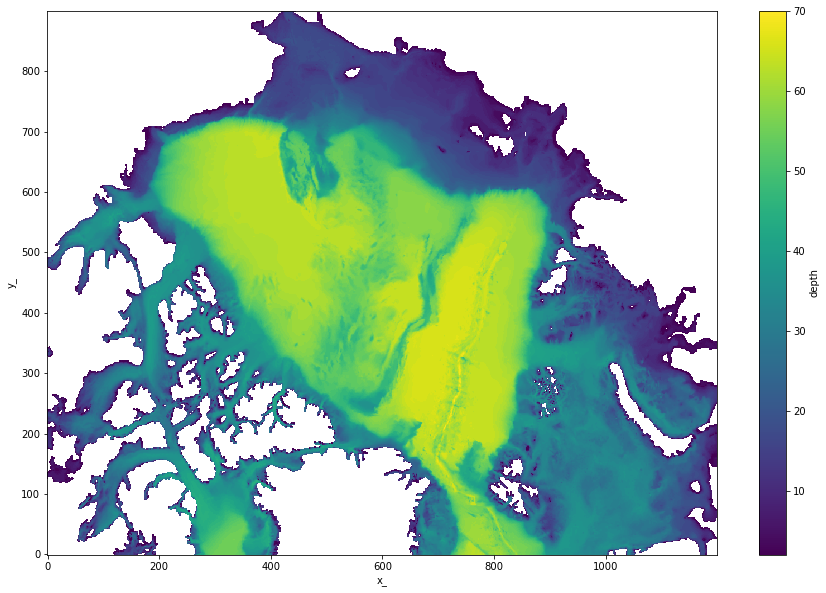

In [39]:
pc.depth.T.plot(figsize = (15,10))

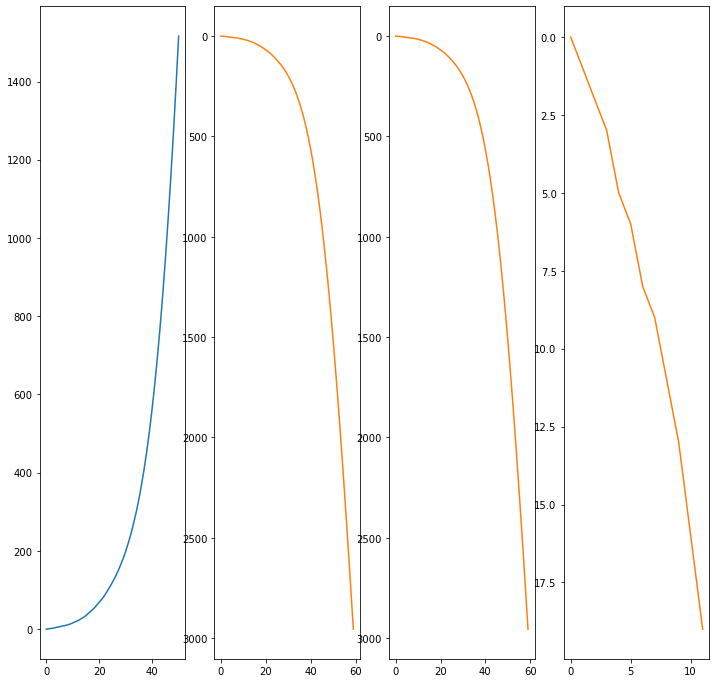

In [133]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize = (12,12))

#ax1.plot(pc.PC11.isel(x_=380,y_=400),pc.PC12.isel(x_=380,y_=400), dyp(pc.depth.isel(x_=380,y_=400).values))
ax1.plot(dyp(pc.depth.isel(x_=380,y_=400).values))
#ax1.invert_yaxis()
ax4.plot(pc.PC11.isel(x_=660,y_=790),pc.PC12.isel(x_=660,y_=790), dyp(pc.depth.isel(x_=660,y_=790).values) )
ax4.invert_yaxis()
ax3.plot(pc.PC11.isel(x_=300,y_=700),pc.PC12.isel(x_=300,y_=700), dyp(pc.depth.isel(x_=300,y_=700).values) )
ax3.invert_yaxis()
ax2.plot(pc.PC11.isel(x_=500,y_=500),pc.PC12.isel(x_=500,y_=500), dyp(pc.depth.isel(x_=500,y_=500).values) )
ax2.invert_yaxis()


# tester med et punkt 

In [ ]:
x_p = 500
y_p = 500 

'Finding the level the given location dosent have values for anymore'

mbathy = ds.mbathy.isel(y=slice(900,1800), x=slice(200,1400))
d = mbathy.isel(x=x_p, y=y_p).values

dyp = u.isel(x=x_p, y=y_p, depth = slice(0,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
punkter = dyp.reduce(5)

cov_p = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise 
values, vectors = np.linalg.eig(cov_p)
order = values.argsort()[::-1]
values, vectors = values[order], vectors[:, order]

print(cov_p.shape) 
print(cov_p)
print('------------------------------------------------------')    
print(values[0]) 
print('------------------------------------------------------')    
print(values[1])
print('------------------------------------------------------')    
print(vectors[0])    